<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
Авторы материала: Ольга Дайховская, Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 
## <center> Обучение без учителя

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://cloud.mail.ru/public/3EJK/cB2VXsyrP). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1ga4KcJdwMWsgEeE76vcTQ34C2iLF7VMhM6nIh_BHUNE).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("../../data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("../../data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../../data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("../../data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [4]:
# Ваш код здесь
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size
y_names = ['ходьба', 'подъему вверх по лестнице', 'спуску по лестнице', 'сидению', 'стоянию', 'лежанию']

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
from sklearn import decomposition
# Ваш код здесь
pca = decomposition.PCA(random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [9]:
# Ваш код здесь
print(np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.9)[0][0] + 1)
for i,v in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    #print(i+1, v)
    if v >= 0.9:
        break

65


**Варианты:**
- 56 
- 65
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [10]:
# Ваш код здесь
pca.explained_variance_ratio_[0]

0.5073822103501332

Визуализируйте данные в проекции на первые две главные компоненты.

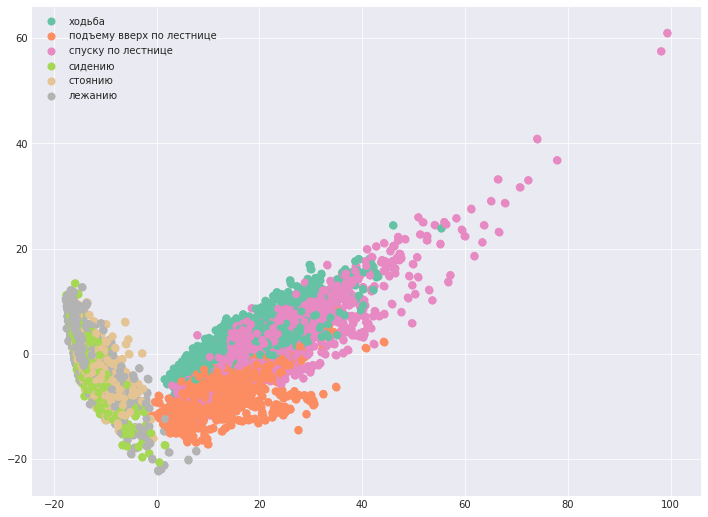

In [11]:
# Ваш код здесь
pca = decomposition.PCA(random_state=RANDOM_STATE, n_components=65)
X_reduced = pca.fit_transform(X_scaled)
for i in range(n_classes):
    c = plt.get_cmap('Set2')(i / (n_classes - 1))
    c = [c[0], c[1], c[2], 1]
    plt.scatter(X_reduced[y == i+1, 0], X_reduced[y == i+1, 1], c=c, s=50);
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y+1, cmap='Set2', s=50);
plt.legend(y_names)

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
X_reduced.shape

(10299, 65)

In [13]:
# Ваш код здесь
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=100).fit(X_reduced)

In [14]:
y_pred = kmeans.predict(X_reduced)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

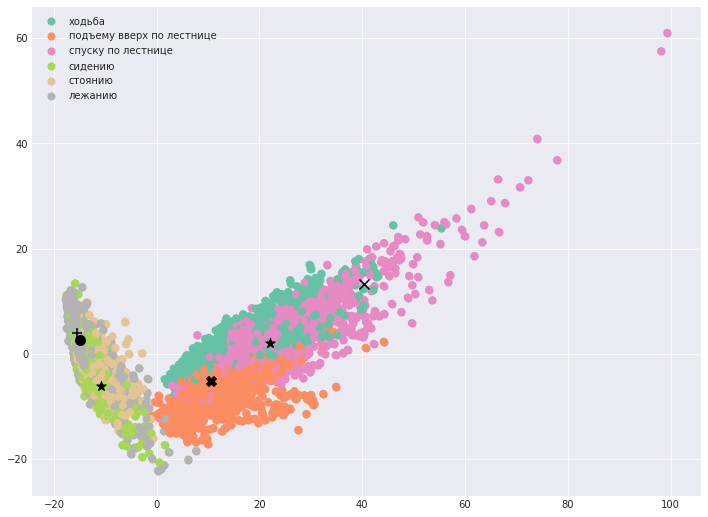

In [15]:
# Ваш код здесь
#plt.scatter(, , c=cluster_labels, s=20,  cmap='viridis');
for i in range(n_classes):
    c = plt.get_cmap('Set2')(i / (n_classes - 1))
    c = [c[0], c[1], c[2], 1]
    plt.scatter(X_reduced[y == i+1, 0], X_reduced[y == i+1, 1], c=c, s=50);
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y+1, cmap='Set2', s=50);
plt.legend(y_names)

markers = ['X', 'o', '*', '+', 'x', '*']
#for i in range(n_classes):
#    c = plt.get_cmap('Set1')(i / (n_classes - 1))
#    plt.scatter(X_reduced[y_pred == i, 0], X_reduced[y_pred == i, 1], c=c, s=50);
for i in range(n_classes):
    plt.scatter(kmeans.cluster_centers_[i, 0], 
                kmeans.cluster_centers_[i, 1], s=100, marker=markers[i], color='black')#, cmap='viridis', s=200)

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [16]:
tab = pd.crosstab(y, y_pred, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab['score'] = tab.iloc[:,:-1].max(axis=1) / tab['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все,score
ходьба,904,0,0,0,78,740,1722,0.524971
подъем вверх по лестнице,1242,0,2,0,5,295,1544,0.804404
спуск по лестнице,320,0,0,0,196,890,1406,0.633001
сидение,1,1235,450,91,0,0,1777,0.694992
стояние,0,1344,562,0,0,0,1906,0.705142
лежание,5,53,329,1557,0,0,1944,0.800926
все,2472,2632,1343,1648,279,1925,10299,0.255559


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- нет верного ответа

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров, смотрите на функцию $D(k)$, описанную в 7-ой [статье](https://habrahabr.ru/company/ods/blog/325654/) курса – "Выбор числа кластеров для kMeans". Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [17]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=100).fit(X_reduced)
    inertia.append(np.sqrt(kmeans.inertia_))
    #
    #

A Jupyter Widget

In [18]:
for i in range(1, 5):
    print(abs(inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i]))

0.173495691711
0.416858170963
0.932823983984
0.629955745119


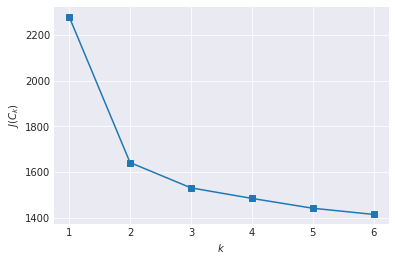

In [157]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, 7), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [19]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_reduced)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [23]:
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=100).fit(X_reduced)

In [25]:
# Ваш код здесь
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(y, ag.labels_))
print(adjusted_rand_score(y, kmeans.labels_))

0.488010997685
0.419677845669


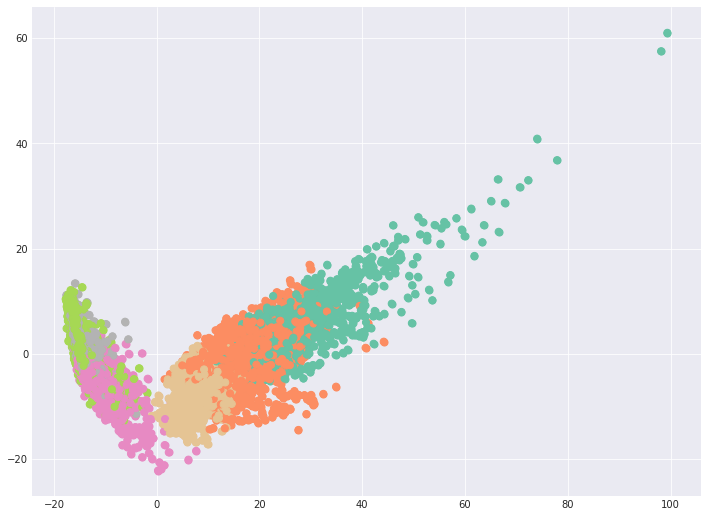

In [27]:
for i in range(n_classes):
    c = plt.get_cmap('Set2')(i / (n_classes - 1))
    c = [c[0], c[1], c[2], 1]
    plt.scatter(X_reduced[ag.labels_ == i, 0], X_reduced[ag.labels_ == i, 1], c=c, s=50);
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=ag.labels_, cmap='Set2', s=50);
#plt.legend(y_names)

**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- ARI выражает сходство меток, полученных после кластеризации, с метками классов для одной и той же выборки, и чем больше значение этого индекса, тем лучше
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения, какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), примените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [30]:
# Ваш код здесь
#
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [37]:
# Ваш код здесь
gs = GridSearchCV(svc, param_grid=svc_params, cv=3)
gs.fit(X_train_scaled, y_train)
best_svc = gs

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [44]:
gs.grid_scores_

C:\Users\Alexandr\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.92533, std: 0.02126, params: {'C': 0.001},
 mean: 0.93621, std: 0.01445, params: {'C': 0.01},
 mean: 0.93825, std: 0.01429, params: {'C': 0.1},
 mean: 0.92873, std: 0.01486, params: {'C': 1},
 mean: 0.92247, std: 0.01386, params: {'C': 10}]

In [40]:
gs.best_estimator_

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0)

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

In [41]:
y_predicted = best_svc.predict(X_test_scaled)

In [42]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
               'сидение', 'стояние', 'лежание', 'все']
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,412,1,1,0,420
сидение,0,4,0,427,60,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,412,443,589,526,2947


Как видим, задача классификации решается неплохо.

**Вопрос 8:**<br>
Путает ли SVM классы внутри выделенных нами ранее (в задании к 3 вопросу) группах активностей? Считаем, что путает, если хотя бы в одном случае алгоритм ошибся.<br>

**Ответ:**
- да
- нет

In [53]:
pca = decomposition.PCA(random_state=RANDOM_STATE).fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [54]:
nc = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.9)[0][0] + 1
print(nc)
X_train_scaled_pca = X_train_scaled_pca[:, :nc]
X_test_scaled_pca = X_test_scaled_pca[:, :nc]

63


In [55]:
gs = GridSearchCV(svc, param_grid=svc_params, cv=3)
gs.fit(X_train_scaled_pca, y_train)
best_svc = gs

In [59]:
gs.cv_results_['mean_test_score']

array([ 0.88084875,  0.8875136 ,  0.89866703,  0.89540261,  0.89186616])

In [60]:
print(gs.best_score_)
0.93825 - gs.best_score_, (0.93825 - gs.best_score_) / 0.93825

0.89866702938


(0.03958297062023941, 0.042188084860367077)

In [51]:
print(gs.best_score_)
0.93825 - gs.best_score_, (0.93825 - gs.best_score_) / 0.93825

0.899619151251


(0.038630848748639868, 0.041173300025195703)

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Используйте тот же PCA, что раньше (сохранить надо 90% дисперсии), обучите его на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% 
- 10%
- 20%


**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, которые плохо интерпретируются человеком
- SVM работает лучше, чем kMeans, поскольку этот алгоритм явно сводится к задаче оптимизации